In [ ]:
import tensorflow as tf

In [ ]:
dataset = tf.data.Dataset.range(10)

In [ ]:
x = list(dataset.as_numpy_iterator())

In [ ]:
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
dataset.take(1)

<TakeDataset shapes: (), types: tf.int64>

In [ ]:
dataset = dataset.window(5, shift=1, drop_remainder=True)

In [ ]:
for window in dataset:
  for val in window:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(5))

In [ ]:
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [ ]:
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

In [ ]:
for window in dataset:
  print(window[0])

tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([2 3 4 5], shape=(4,), dtype=int64)
tf.Tensor([3 4 5 6], shape=(4,), dtype=int64)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int64)
tf.Tensor([5 6 7 8], shape=(4,), dtype=int64)


In [ ]:
dataset = dataset.shuffle(buffer_size=10)

In [ ]:
for window in dataset:
  print(window)

(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 4, 5, 6])>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([4, 5, 6, 7])>, <tf.Tensor: shape=(), dtype=int64, numpy=8>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([2, 3, 4, 5])>, <tf.Tensor: shape=(), dtype=int64, numpy=6>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([5, 6, 7, 8])>, <tf.Tensor: shape=(), dtype=int64, numpy=9>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)


In [ ]:
dataset = dataset.batch(2)

In [ ]:
for window in dataset:
  print(window)

(<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[4, 5, 6, 7],
       [0, 1, 2, 3]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([8, 4])>)
(<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[1, 2, 3, 4],
       [2, 3, 4, 5]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([5, 6])>)
(<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[3, 4, 5, 6],
       [5, 6, 7, 8]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 9])>)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

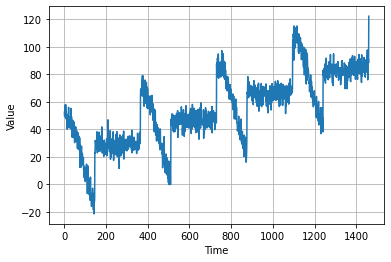

In [ ]:
plot_series(time, series)

In [ ]:
time

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.458e+03, 1.459e+03,
       1.460e+03], dtype=float32)

In [ ]:
series

array([ 52.48357 ,  49.35275 ,  53.314735, ...,  91.37325 ,  88.32383 ,
       122.30772 ], dtype=float32)

In [ ]:
window_size = 20
batch_size = 32
shuffle_size = 1000

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]



In [ ]:
def windowed_ds(series, window_size, batch_size, shuffle_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_size).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_ds(series, window_size, batch_size, shuffle_size)

In [ ]:
for item in dataset:
  print(item)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
         46.676632  ,  45.44373   ,  52.040035  ,  47.452827  ,
         47.84891   ,  44.082253  ,  43.68492   ,  43.942028  ,
         48.05951   ,  43.965313  ,  47.50264   ,  56.41485   ],
       [ 65.38135   ,  69.759796  ,  59.24037   ,  65.01967   ,
         60.836647  ,  70.29547   ,  56.687828  ,  61.493233  ,
         66.15852   ,  72.08523   ,  63.914536  ,  61.453503  ,
         73.62201   ,  56.963406  ,  53.19721   ,  66.379585  ,
         61.65801   ,  59.0514    ,  67.68912   ,  65.356606  ],
       [ 50.720642  ,  44.454983  ,  41.76799   ,  55.980938  ,
         47.335835  ,  48.6033    ,  40.93184   ,  45.11266   ,
         48.15732   ,  41.6051    ,  48.985233  ,  43.839634  ,
         45.109936  ,  43.275043  ,  55.249832  ,  45.615612  ,
         40.079105  ,  49.154957  ,  38.602703  ,  45.406162  ],
       [ 29.869114  ,  32.418423  ,  31.52398   ,  24.252817  ,
         25.619074  ,  32.178864  ,  31.5168

In [ ]:
model = tf.keras.models.Sequential()

In [ ]:
dense1 = tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu')
dense2 = tf.keras.layers.Dense(10, activation='relu')
dense3 = tf.keras.layers.Dense(1)

In [ ]:
model.add(dense1)
model.add(dense2)
model.add(dense3)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
46/46 [==============================] - 0s 3ms/step - loss: 369.7189
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 71.4899
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 63.9489
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 66.7899
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 61.0656
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 60.7172
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 58.9501
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 59.0216
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 57.9703
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 58.8687
Epoch 11/100
46/46 [==============================] - 0s 3ms/step - loss: 56.6990
Epoch 12/100
46/46 [==============================] - 0s 3ms/step - loss: 56.2507
Epoch 13/100
46/46 [====

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

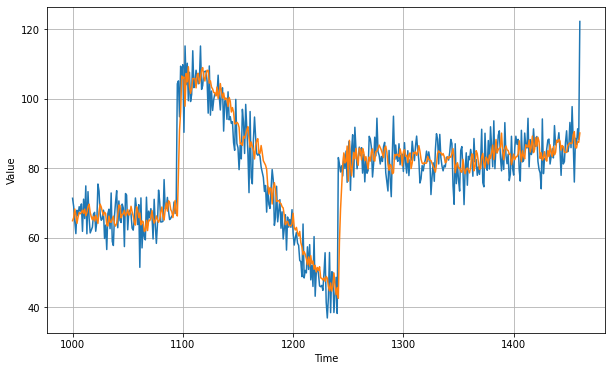

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


TypeError: ignored

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds


In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1 , drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Bidirectional
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# clear_session()
# tf.random.set_seed(51)
# np.random.seed(51)

# window_size = 64
# batch_size = 256

# train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(train_set)
# print(x_train.shape)

# def model(input_shape):
#     input = Input(shape=input_shape)
#     x = input
#     x = Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu')(x)
#     x = LSTM(64, return_sequences=True)(x)
#     x = LSTM(64, return_sequences=True)(x)
#     x = Dense(30, activation='relu')(x)
#     x = Dense(10, activation='relu')(x)
#     x = Dense(1)(x)
#     model = Model(input, x)
#     return model
# model = Sequential([
#                     Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
#                     LSTM(64, return_sequences=True),
#                     LSTM(64, return_sequences=True),
#                     Dense(30, activation='relu'),
#                     Dense(10, activation='relu'),
#                     Dense(1),
#                     Lambda(lambda x: x * 400)
# ])
# for tensor in model.layers:
#   print(tensor)
# model = model(input_shape=[None, 1])
# model.summary()

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
# optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])
# history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
# plt.semilogx(history.history['lr'], history.history['loss'])
# plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
checkpoint = ModelCheckpoint(filepath='model.h5', monitor='mae', verbose=0, save_best_only=True)

In [ ]:
clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
                    Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=[None, 1]),
                    LSTM(64, return_sequences=True),
                    LSTM(64, return_sequences=True),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

In [ ]:

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
import numpy as np

In [ ]:
time = np.arange(4 * 365 + 1)

In [ ]:
def trend(time, slope):
    return time * slope

In [ ]:
series = trend(0.1)

In [ ]:
series

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.458e+02, 1.459e+02,
       1.460e+02])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series):
    plt.figure(figsize=(10, 6))
    plt.plot(time, series)
    plt.xlabel("time")
    plt.ylabel("value")
    plt.grid(True)
    plt.show()

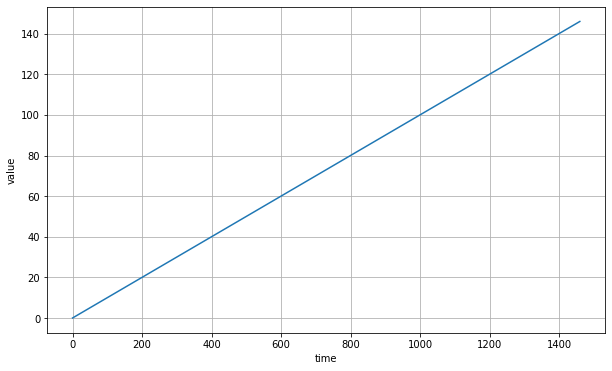

In [ ]:
plot_series(time, series)

In [ ]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

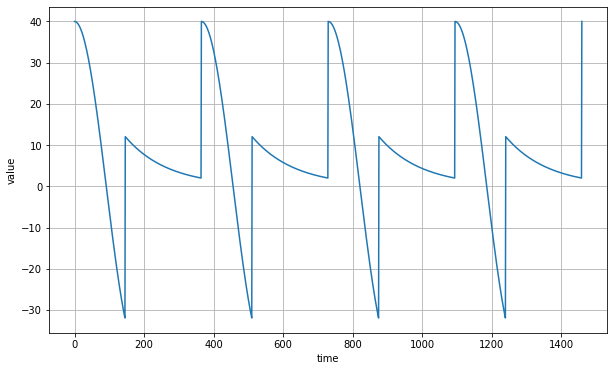

In [ ]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)
plot_series(time, series)

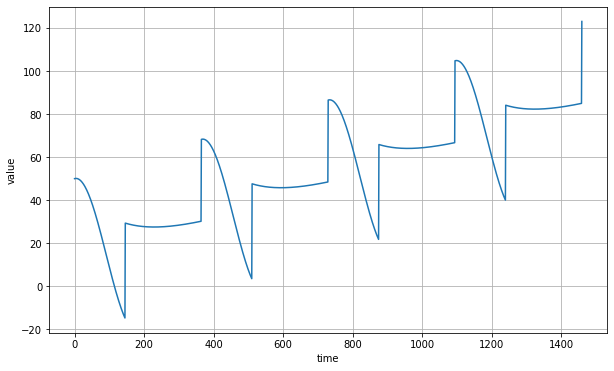

In [ ]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
plot_series(time, series)

In [ ]:
def noise(time, noise_level=1):
    return np.random.randn(len(time)) * noise_level

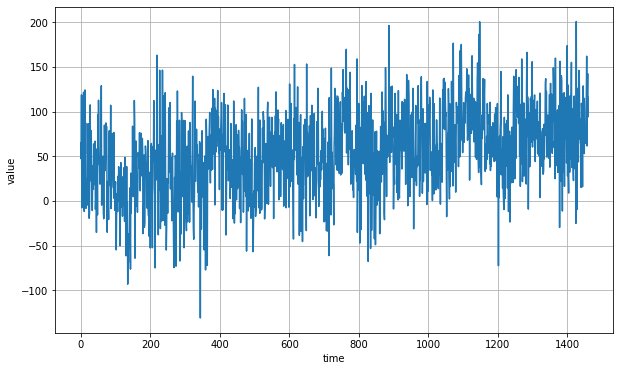

In [ ]:
noise_level = 40
noisy_series = series + noise(time, noise_level)
plot_series(time, noisy_series)